# Name of the Student : Aagam Manish Shah

# USC ID Number : 8791018480

# 7.2 (Deep) CNNs for Image Colorization

## (g) Extra Practice: Repeat the whole exercise with k = 24 colors if your computer can handle the computations.

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras
from sklearn.cluster import KMeans
from skimage.color import rgb2gray
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
for module in keras, sklearn, tf:
  print("{} version is {}".format(module.__name__, module.__version__))

tensorflow.keras version is 2.3.0-tf
sklearn version is 0.22.2.post1
tensorflow version is 2.2.0


In [4]:
from keras.datasets import cifar10
(X_train_total, y_train_total), (X_test_total, y_test_total) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step


In [5]:
print("-----------------Before Extraction----------------")
print("Training Dataset: ", X_train_total.shape, y_train_total.shape)
print("Testing Dataset: ", X_test_total.shape, y_test_total.shape)

-----------------Before Extraction----------------
Training Dataset:  (50000, 32, 32, 3) (50000, 1)
Testing Dataset:  (10000, 32, 32, 3) (10000, 1)


In [6]:
X_train_reshape = X_train_total.reshape(-1, 32*32*3)
y_train_reshape = y_train_total.reshape(-1)

X_test_reshape = X_test_total.reshape(-1, 32*32*3)
y_test_reshape = y_test_total.reshape(-1)

X_train = X_train_reshape[y_train_reshape == 2].reshape(-1, 32, 32, 3)
y_train = y_train_reshape[y_train_reshape == 2]

X_test = X_test_reshape[y_test_reshape == 2].reshape(-1, 32, 32, 3)
y_test = y_test_reshape[y_test_reshape == 2]

In [7]:
print("-----------------After Extraction-----------------")
print("Training Dataset: ", X_train.shape, y_train.shape)
print("Testing Dataset: ", X_test.shape, y_test.shape)

-----------------After Extraction-----------------
Training Dataset:  (5000, 32, 32, 3) (5000,)
Testing Dataset:  (1000, 32, 32, 3) (1000,)


Concatenated Data Set:  (6000, 32, 32, 3) (6000,)
-----------------Original Image-----------------


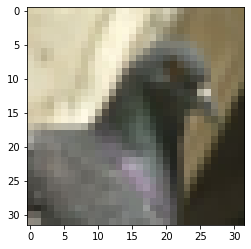

In [8]:
X_data = np.concatenate((X_train,X_test))
y_data = np.concatenate((y_train,y_test))

print("Concatenated Data Set: ", X_data.shape, y_data.shape)
print("-----------------Original Image-----------------")
plt.imshow(X_data[666])

In [9]:
X_data_new = X_data.reshape(-1, 3)
k_means_clf = KMeans(n_clusters=24, random_state=2333, n_init=10).fit(X_data_new)
main_colors = k_means_clf.cluster_centers_
y_predict = k_means_clf.labels_

-----------------Converted Image-----------------


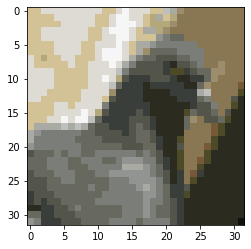

In [10]:
X_converted = np.array([main_colors[y_predict[i]] for i in range(len(X_data_new))], dtype=np.uint8).reshape(-1, 32, 32, 3)

print("-----------------Converted Image-----------------")
plt.imshow(X_converted[666])

-----------------Grayscale Image-----------------


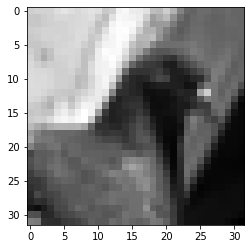

In [11]:
X_grayscale = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print("-----------------Grayscale Image-----------------")
plt.imshow(X_grayscale[666], cmap=plt.cm.gray)

In [12]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 24)
X_train_grayscale, X_test_grayscale, y_train_grayscale, y_test_grayscale = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)
X_train_grayscale.shape,y_train_grayscale.shape, X_test_grayscale.shape, y_test_grayscale.shape

((5400, 32, 32, 1), (5400, 32, 32, 24), (600, 32, 32, 1), (600, 32, 32, 24))

In [16]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(32, activation="softmax"),
    keras.layers.Dense(24, activation="softmax")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 24)        792       
Total params: 107,000
Trainable params: 107,000
Non-trainable params: 0
________________________________________________

In [17]:
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [18]:
number_of_epochs = 30
output_directory = "./cnn_checkpoint2"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
checkpoint_prefix = os.path.join(output_directory, 'ck_{epoch:02d}.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,save_weights_only= True)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_grayscale, y_train_grayscale, epochs=number_of_epochs, validation_data=(X_test_grayscale, y_test_grayscale), callbacks=[checkpoint_callback, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 110s 649ms/step - loss: 3.1762 - accuracy: 0.0475 - val_loss: 3.1762 - val_accuracy: 0.0458
Epoch 2/30
169/169 [==============================] - 109s 647ms/step - loss: 3.1750 - accuracy: 0.0475 - val_loss: 3.1750 - val_accuracy: 0.0458
Epoch 3/30
169/169 [==============================] - 109s 645ms/step - loss: 3.1738 - accuracy: 0.0475 - val_loss: 3.1737 - val_accuracy: 0.0458
Epoch 4/30
169/169 [==============================] - 109s 644ms/step - loss: 3.1726 - accuracy: 0.0475 - val_loss: 3.1725 - val_accuracy: 0.0458
Epoch 5/30
169/169 [==============================] - 110s 650ms/step - loss: 3.1714 - accuracy: 0.0475 - val_loss: 3.1714 - val_accuracy: 0.0458
Epoch 6/30
169/169 [==============================] - 108s 638ms/step - loss: 3.1703 - accuracy: 0.0475 - val_loss: 3.1702 - val_accuracy: 0.0458
Epoch 7/30
169/169 [==============================] - 107s 635ms/step - loss: 3.1692 - accuracy: 0.0476 - val_loss: 3.1690 -

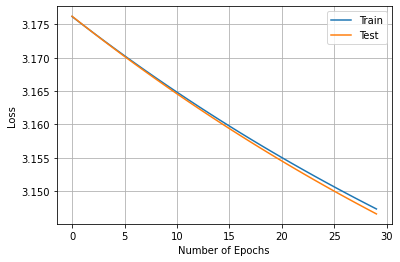

In [19]:
def plot_error_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.gca()
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
plot_error_curves(history)

In [20]:
y_pred_color = model.predict(X_test_grayscale)
y_pred_color = y_pred_color.reshape(X_test_grayscale.shape[0] * 32 * 32, 24)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_new = y_test_grayscale.reshape(X_test_grayscale.shape[0] * 32 * 32, 24)
y_test_k_color = []
for i in range(len(y_test_new)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_new[i])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

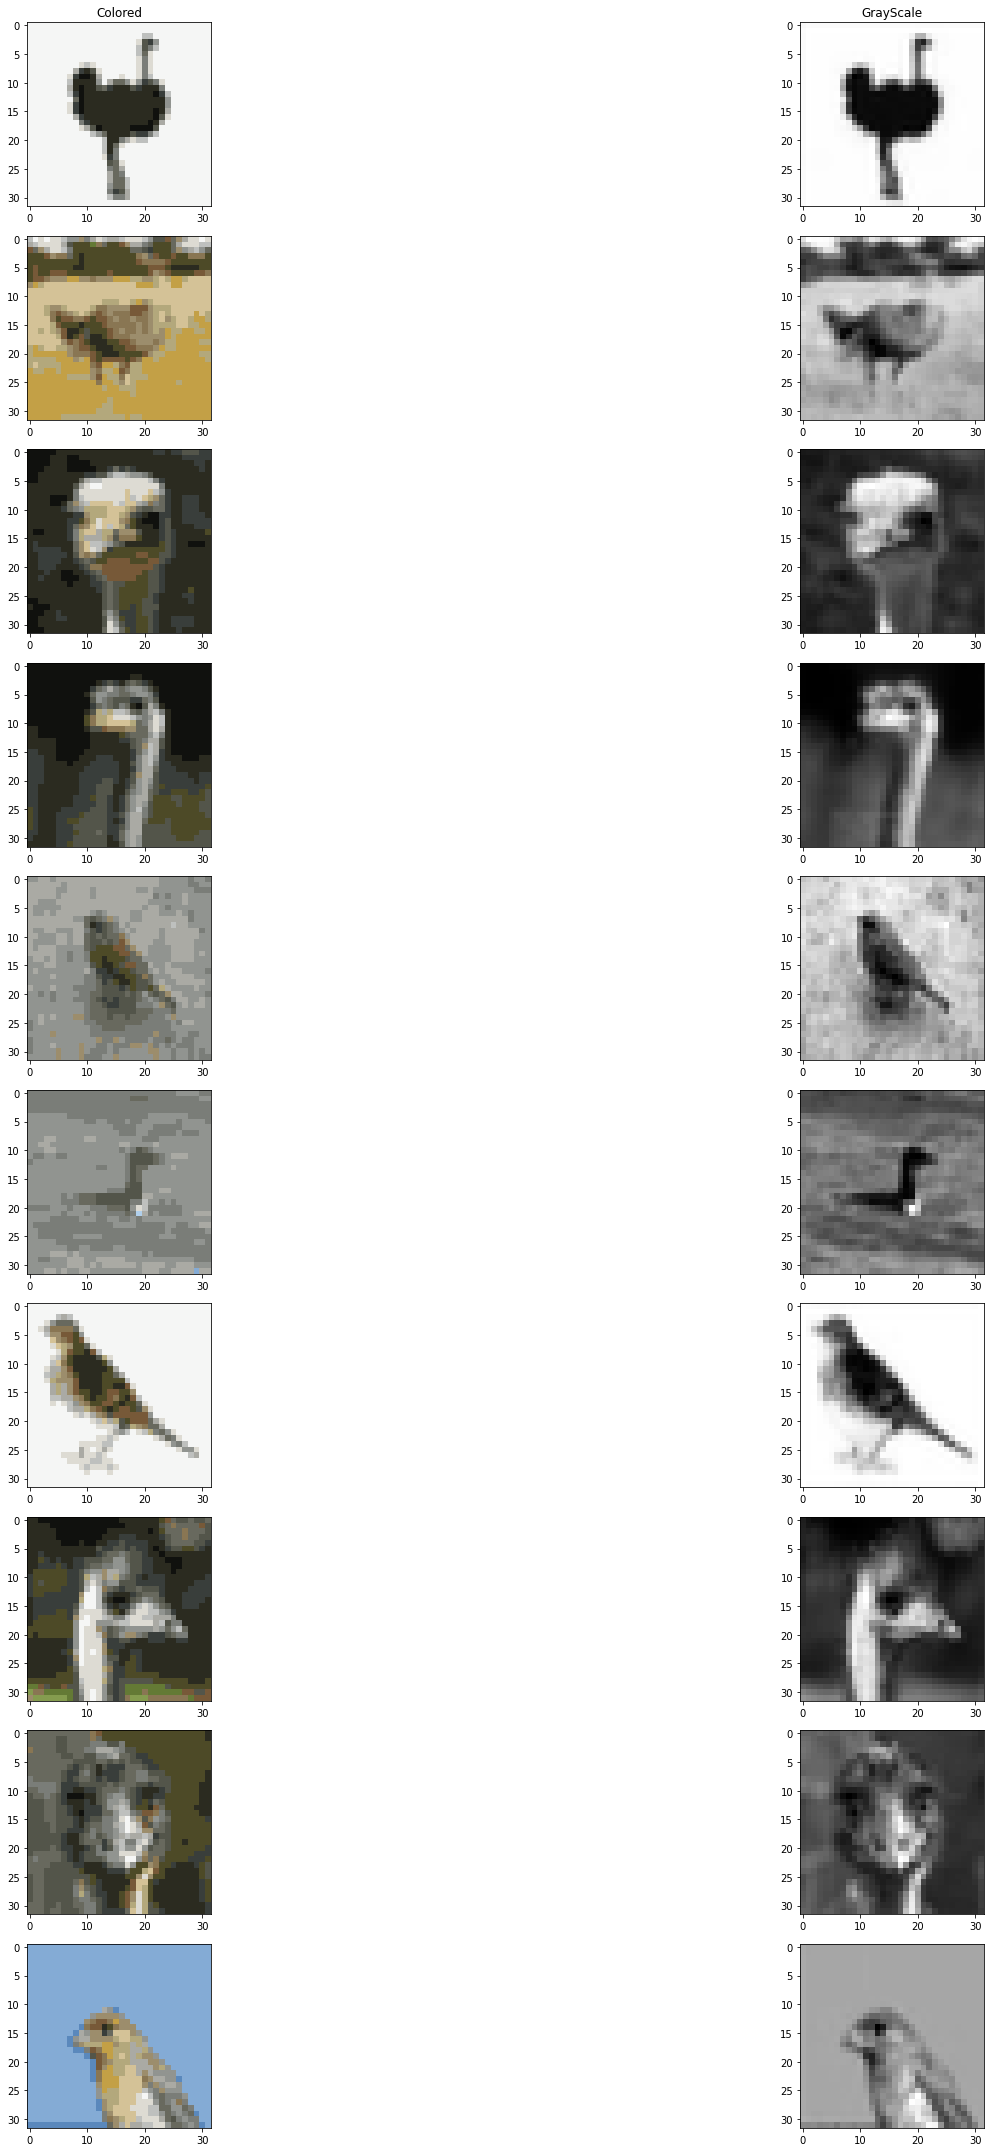

In [21]:
fig, axes = plt.subplots(10, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[1])
ax[1].imshow(X_test_grayscale.reshape(-1,32,32)[1], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[2])
ax[3].imshow(X_test_grayscale.reshape(-1,32,32)[2], cmap=plt.cm.gray)

ax[4].imshow(y_test_k_color[3])
ax[5].imshow(X_test_grayscale.reshape(-1,32,32)[3], cmap=plt.cm.gray)

ax[6].imshow(y_test_k_color[4])
ax[7].imshow(X_test_grayscale.reshape(-1,32,32)[4], cmap=plt.cm.gray)

ax[8].imshow(y_test_k_color[5])
ax[9].imshow(X_test_grayscale.reshape(-1,32,32)[5], cmap=plt.cm.gray)

ax[10].imshow(y_test_k_color[6])
ax[11].imshow(X_test_grayscale.reshape(-1,32,32)[6], cmap=plt.cm.gray)

ax[12].imshow(y_test_k_color[7])
ax[13].imshow(X_test_grayscale.reshape(-1,32,32)[7], cmap=plt.cm.gray)

ax[14].imshow(y_test_k_color[8])
ax[15].imshow(X_test_grayscale.reshape(-1,32,32)[8], cmap=plt.cm.gray)

ax[16].imshow(y_test_k_color[9])
ax[17].imshow(X_test_grayscale.reshape(-1,32,32)[9], cmap=plt.cm.gray)

ax[18].imshow(y_test_k_color[10])
ax[19].imshow(X_test_grayscale.reshape(-1,32,32)[10], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("GrayScale")

fig.tight_layout()
plt.show()

## (g) Extra Practice: Repeat the whole exercise with k = 32 colors if your computer can handle the computations.

In [22]:
X_data_new = X_data.reshape(-1, 3)
k_means_clf = KMeans(n_clusters=32, random_state=2333, n_init=10).fit(X_data_new)
main_colors = k_means_clf.cluster_centers_
y_predict = k_means_clf.labels_

-----------------Converted Image-----------------


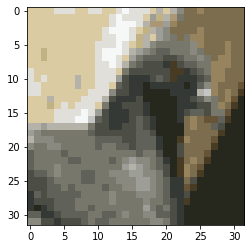

In [23]:
X_converted = np.array([main_colors[y_predict[i]] for i in range(len(X_data_new))], dtype=np.uint8).reshape(-1, 32, 32, 3)

print("-----------------Converted Image-----------------")
plt.imshow(X_converted[666])

-----------------Grayscale Image-----------------


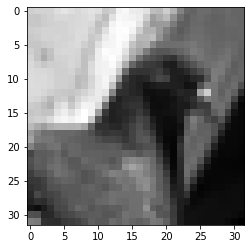

In [24]:
X_grayscale = np.array([rgb2gray(X_data[i]) for i in range(len(X_data))])
print("-----------------Grayscale Image-----------------")
plt.imshow(X_grayscale[666], cmap=plt.cm.gray)

In [25]:
encoder = OneHotEncoder(handle_unknown='ignore')
y_sample = [[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31]]
encoder.fit(y_sample)
y_encoded = encoder.transform(y_predict.reshape(-1, 1)).toarray().astype(int).reshape(-1, 32, 32, 32)
X_train_grayscale, X_test_grayscale, y_train_grayscale, y_test_grayscale = train_test_split(X_grayscale.reshape(-1, 32, 32, 1), y_encoded, test_size=0.1, random_state=666)
X_train_grayscale.shape,y_train_grayscale.shape, X_test_grayscale.shape, y_test_grayscale.shape

((5400, 32, 32, 1), (5400, 32, 32, 32), (600, 32, 32, 1), (600, 32, 32, 32))

In [31]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu', input_shape=(32,32,1)),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1, 1), padding='same', activation='relu'),
    keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'),
    keras.layers.Dense(32, activation="softmax"),
    keras.layers.Dense(32, activation="softmax")
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 64)        1664      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 64)        102464    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
dense_5 (Dense)              (None, 32, 32, 32)        2080      
_________________________________________________________________
dense_6 (Dense)              (None, 32, 32, 32)        1056      
Total params: 107,264
Trainable params: 107,264
Non-trainable params: 0
________________________________________________

In [32]:
model.compile(optimizer=keras.optimizers.SGD(0.001), loss='categorical_crossentropy', metrics=["accuracy"])

In [33]:
number_of_epochs = 30
output_directory = "./cnn_checkpoint3"
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
    
checkpoint_prefix = os.path.join(output_directory, 'ck_{epoch:02d}.hdf5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath = checkpoint_prefix,save_weights_only= True)
earlyStoppingCk = keras.callbacks.EarlyStopping(patience = 5, min_delta = 1e-4)

history = model.fit(X_train_grayscale, y_train_grayscale, epochs=number_of_epochs, validation_data=(X_test_grayscale, y_test_grayscale), callbacks=[checkpoint_callback, earlyStoppingCk])

Epoch 1/30
169/169 [==============================] - 109s 642ms/step - loss: 3.4627 - accuracy: 0.0174 - val_loss: 3.4617 - val_accuracy: 0.0248
Epoch 2/30
169/169 [==============================] - 109s 644ms/step - loss: 3.4615 - accuracy: 0.0533 - val_loss: 3.4605 - val_accuracy: 0.0621
Epoch 3/30
169/169 [==============================] - 109s 647ms/step - loss: 3.4603 - accuracy: 0.0573 - val_loss: 3.4593 - val_accuracy: 0.0621
Epoch 4/30
169/169 [==============================] - 110s 648ms/step - loss: 3.4590 - accuracy: 0.0573 - val_loss: 3.4580 - val_accuracy: 0.0621
Epoch 5/30
169/169 [==============================] - 109s 647ms/step - loss: 3.4578 - accuracy: 0.0573 - val_loss: 3.4568 - val_accuracy: 0.0621
Epoch 6/30
169/169 [==============================] - 109s 646ms/step - loss: 3.4567 - accuracy: 0.0573 - val_loss: 3.4557 - val_accuracy: 0.0621
Epoch 7/30
169/169 [==============================] - 110s 648ms/step - loss: 3.4555 - accuracy: 0.0573 - val_loss: 3.4545 -

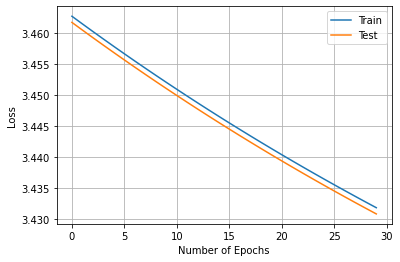

In [34]:
def plot_error_curves(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.grid(True)
    plt.gca()
    plt.ylabel('Loss')
    plt.xlabel('Number of Epochs')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()
    
plot_error_curves(history)

In [35]:
y_pred_color = model.predict(X_test_grayscale)
y_pred_color = y_pred_color.reshape(X_test_grayscale.shape[0] * 32 * 32, 32)
output_images = []
for index in range(len(y_pred_color)):
    output_images.append([int(color) for color in main_colors[np.argmax(y_pred_color[index])]])
    
y_test_new = y_test_grayscale.reshape(X_test_grayscale.shape[0] * 32 * 32, 32)
y_test_k_color = []
for i in range(len(y_test_new)):
    y_test_k_color.append([int(color) for color in main_colors[np.argmax(y_test_new[i])]])
output_images = np.reshape(output_images, (-1, 32, 32, 3))
y_test_k_color = np.reshape(y_test_k_color, (-1, 32, 32, 3))

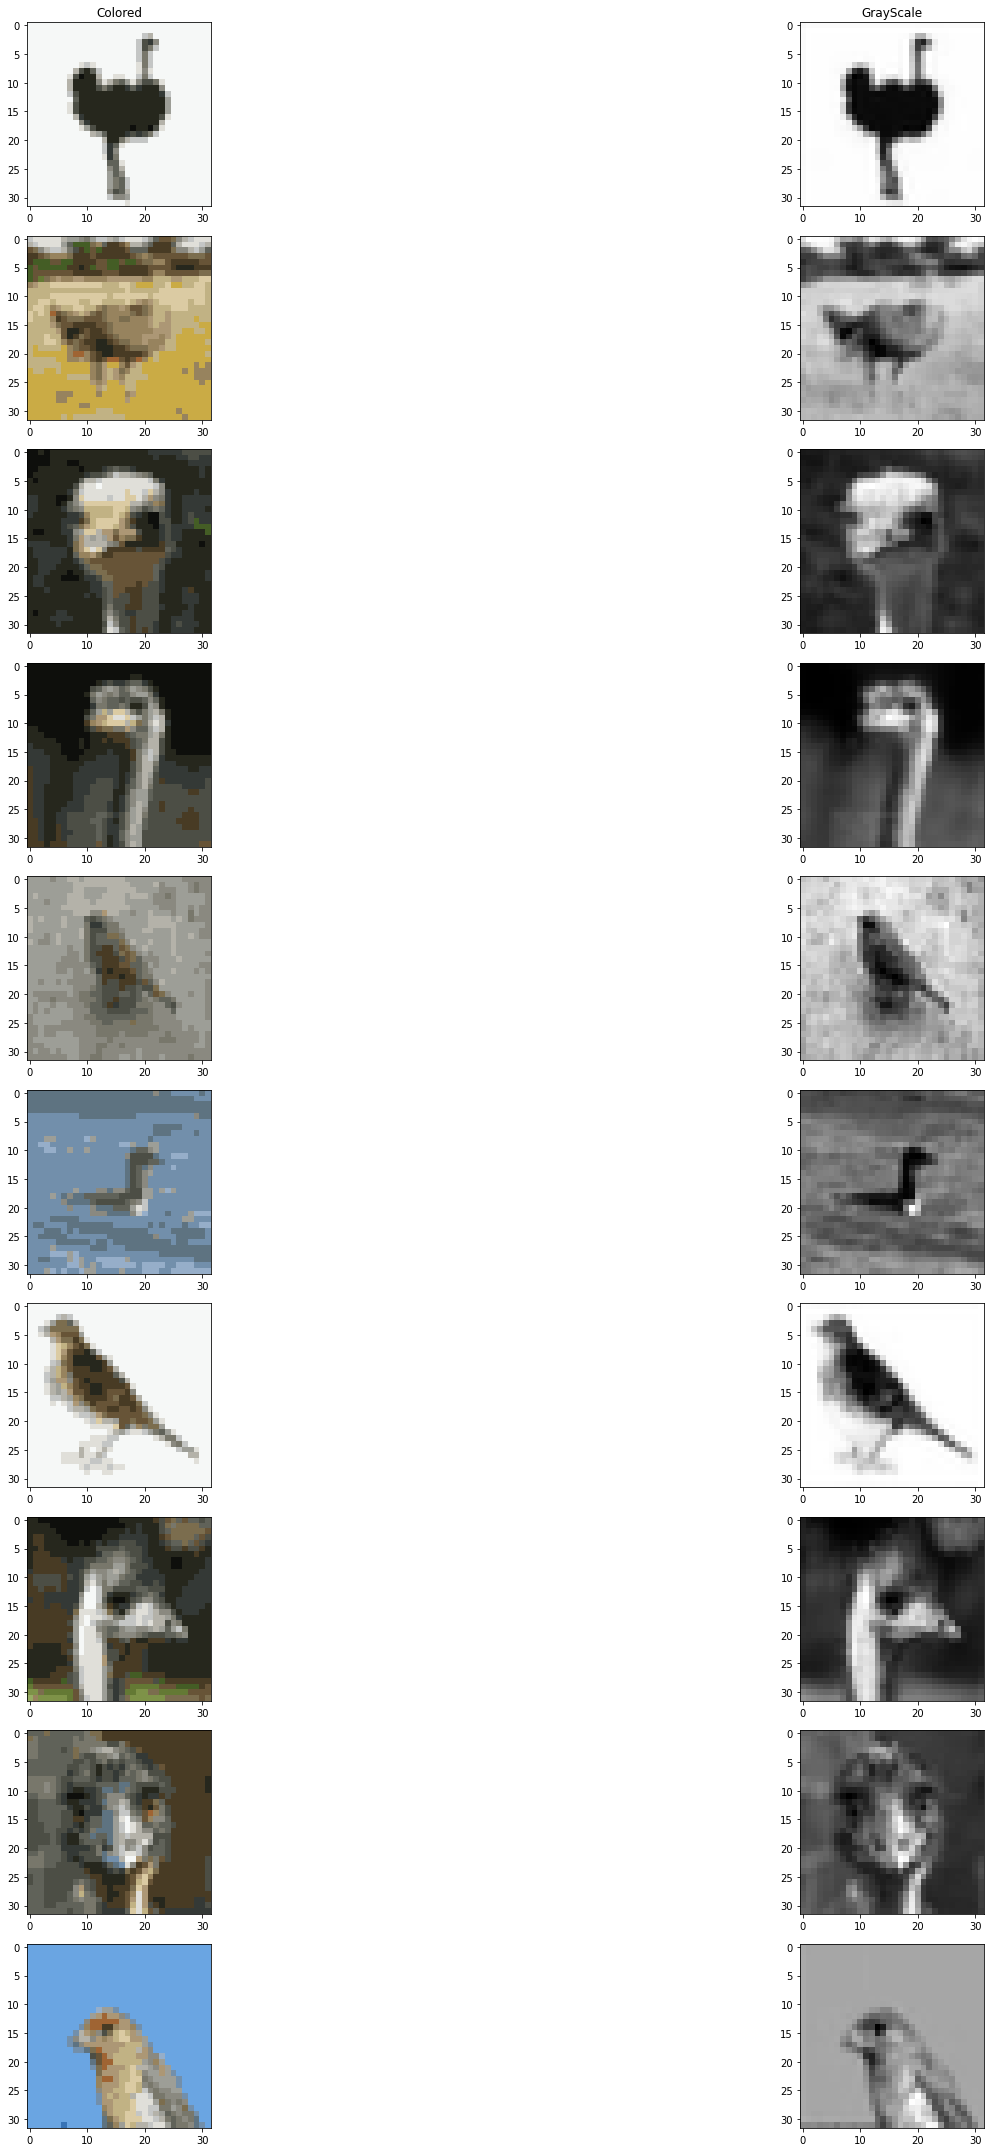

In [36]:
fig, axes = plt.subplots(10, 2, figsize=(30, 30))
ax = axes.ravel()

ax[0].imshow(y_test_k_color[1])
ax[1].imshow(X_test_grayscale.reshape(-1,32,32)[1], cmap=plt.cm.gray)

ax[2].imshow(y_test_k_color[2])
ax[3].imshow(X_test_grayscale.reshape(-1,32,32)[2], cmap=plt.cm.gray)

ax[4].imshow(y_test_k_color[3])
ax[5].imshow(X_test_grayscale.reshape(-1,32,32)[3], cmap=plt.cm.gray)

ax[6].imshow(y_test_k_color[4])
ax[7].imshow(X_test_grayscale.reshape(-1,32,32)[4], cmap=plt.cm.gray)

ax[8].imshow(y_test_k_color[5])
ax[9].imshow(X_test_grayscale.reshape(-1,32,32)[5], cmap=plt.cm.gray)

ax[10].imshow(y_test_k_color[6])
ax[11].imshow(X_test_grayscale.reshape(-1,32,32)[6], cmap=plt.cm.gray)

ax[12].imshow(y_test_k_color[7])
ax[13].imshow(X_test_grayscale.reshape(-1,32,32)[7], cmap=plt.cm.gray)

ax[14].imshow(y_test_k_color[8])
ax[15].imshow(X_test_grayscale.reshape(-1,32,32)[8], cmap=plt.cm.gray)

ax[16].imshow(y_test_k_color[9])
ax[17].imshow(X_test_grayscale.reshape(-1,32,32)[9], cmap=plt.cm.gray)

ax[18].imshow(y_test_k_color[10])
ax[19].imshow(X_test_grayscale.reshape(-1,32,32)[10], cmap=plt.cm.gray)

ax[0].set_title("Colored")
ax[1].set_title("GrayScale")

fig.tight_layout()
plt.show()